In [93]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Carga de imagenes

En esta sección realizamos la preparación y carga del conjunto de datos de imágenes para la detección de carreteras. En la primera iteración las imagenes no estaban en par con las mascaras, por lo que realizamos una ordenación para asegurar que los pares se cargen correctamente.

## Estructura del dataset
El conjunto de datos está organizado en dos directorios principales:
- `roads/sat/`: Contiene las imágenes satelitales en formato `.tiff`
- `roads/gt/`: Contiene las máscaras de ground truth en formato `.tif`

## Características del dataset:
   - Imágenes satelitales RGB
   - Máscaras binarias donde 1 representa carretera y 0 no carretera
   - Redimensionado de las imagenes de TAMAÑOxTAMAÑO a 512x512 píxeles para reducir la carga computacional.

In [94]:
# Función para obtener rutas ordenadas por nombre de archivo
def get_sorted_paths(folder, extension="tiff"):
    return sorted(
        [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(extension)]
    )

# Rutas de las imágenes y las máscaras
img_paths = get_sorted_paths("roads/sat", extension="tiff")
mask_paths = get_sorted_paths("roads/gt", extension="tif")

# Verifica que el orden coincida
for img, mask in zip(img_paths, mask_paths):
    print(f"Imagen: {os.path.basename(img)}, Máscara: {os.path.basename(mask)}")

# Verificar si se encontraron archivos
if len(img_paths) == 0 or len(mask_paths) == 0:
    print("No se encontraron imágenes o máscaras. Verifica las rutas.")
else:
    print(f"Imágenes encontradas: {len(img_paths)} | Máscaras encontradas: {len(mask_paths)}")


Imagen: 10078675_15.tiff, Máscara: 10078675_15.tif
Imagen: 10228675_15.tiff, Máscara: 10228675_15.tif
Imagen: 10228705_15.tiff, Máscara: 10228705_15.tif
Imagen: 10228720_15.tiff, Máscara: 10228720_15.tif
Imagen: 10228735_15.tiff, Máscara: 10228735_15.tif
Imagen: 10228750_15.tiff, Máscara: 10228750_15.tif
Imagen: 10378675_15.tiff, Máscara: 10378675_15.tif
Imagen: 10378690_15.tiff, Máscara: 10378690_15.tif
Imagen: 10378705_15.tiff, Máscara: 10378705_15.tif
Imagen: 10378720_15.tiff, Máscara: 10378720_15.tif
Imagen: 10378735_15.tiff, Máscara: 10378735_15.tif
Imagen: 10378750_15.tiff, Máscara: 10378750_15.tif
Imagen: 10378765_15.tiff, Máscara: 10378765_15.tif
Imagen: 10528675_15.tiff, Máscara: 10528675_15.tif
Imagen: 10528690_15.tiff, Máscara: 10528690_15.tif
Imagen: 10528705_15.tiff, Máscara: 10528705_15.tif
Imagen: 10528720_15.tiff, Máscara: 10528720_15.tif
Imagen: 10528735_15.tiff, Máscara: 10528735_15.tif
Imagen: 10528750_15.tiff, Máscara: 10528750_15.tif
Imagen: 10528765_15.tiff, Másca

## Preprocesado

Inicialmente, implementamos varias técnicas de preprocesamiento para intentar mejorar la calidad de las imágenes y los resultados de la segmentación. Sin embargo, tras realizar diversos experimentos, descubrimos que estas técnicas en realidad no afectaban realmente al resultado final. Por esta razón, mantenemos estas funciones documentadas pero desactivadas en el proceso final por simplificación.

## Técnicas de Preprocesamiento Implementadas

### 1. Estandarización de Imágenes (`standardize_image`)
Esta función normaliza cada canal de color de manera independiente:
- Calcula media y desviación estándar por canal
- Aplica normalización Z-score
- Escala los valores al rango [0,1], para evitar salidas de rango en la imagen

### 2. Mejora de Contraste (`enhance_contrast`)
Aplica mejora de contraste adaptativa:
- Convierte la imagen al espacio de color LAB, tenemos que pasar a 255 aplicar las funciones
- Aplica CLAHE (Contrast Limited Adaptive Histogram Equalization) al canal L
- Utiliza parámetros suaves (`clipLimit=1.0`, `tileGridSize=(8,8)`)

### 3. Reducción de Ruido (`reduce_noise`)
- Preserva bordes mientras reduce ruido

In [95]:
def standardize_image(img):
    normalized_img = np.zeros_like(img, dtype='float32')
    for channel in range(img.shape[-1]):
        img_channel = img[..., channel].astype('float32')
        mean = np.mean(img_channel)
        std = np.std(img_channel)
        # Z-score normalización
        normalized_channel = (img_channel - mean) / (std + 1e-7)
        # Escalar a [0,1]
        normalized_channel = (normalized_channel - normalized_channel.min()) / (normalized_channel.max() - normalized_channel.min())
        normalized_img[..., channel] = normalized_channel
    return normalized_img

def enhance_contrast(img):
    """
    Mejora el contraste usando CLAHE.
    Entrada: imagen en formato float32 [0,1]
    Salida: imagen en formato float32 [0,1]
    """
    # Convertir a uint8 para CLAHE
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Convertir a LAB
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    # Combinar canales y convertir de vuelta a BGR
    enhanced = cv2.merge([l, a, b])
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)
    
    # Convertir de vuelta a float32 [0,1]
    return enhanced.astype('float32') / 255.0

def reduce_noise(img):
    denoised = cv2.bilateralFilter(img, 
                                 d=7,
                                 sigmaColor=50,
                                 sigmaSpace=50)
    return denoised.astype('float32') / 255.0

## Carga de los datos

In [96]:
def load_data(img_paths, mask_paths, img_size=(512, 512), preprocess=True):
    imgs = []
    masks = []
    
    for img_path, mask_path in zip(img_paths, mask_paths):
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found: {mask_path}")
                
            # Carga de las imagenes y preprocesado
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Failed to load image: {img_path}")
            img = cv2.resize(img, img_size)
            
            if preprocess:
                img = reduce_noise(img)
                img = enhance_contrast(img)
                img = standardize_image(img)
            else:
                # Solo normalizar si no hay preprocesado
                img = img.astype('float32') / 255.0
                
            imgs.append(img)
            
            # Carga y binarizacion de las mascaras
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Failed to load mask: {mask_path}")
            mask = cv2.resize(mask, img_size)
            mask = (mask > 0).astype('float32')
            masks.append(mask)
            
    return np.array(imgs), np.array(masks)

IMAGES, MASKS = load_data(img_paths, mask_paths, preprocess=False)
print("Number of images: " , len(IMAGES), "Number of masks: ", len(MASKS))

Number of images:  20 Number of masks:  20


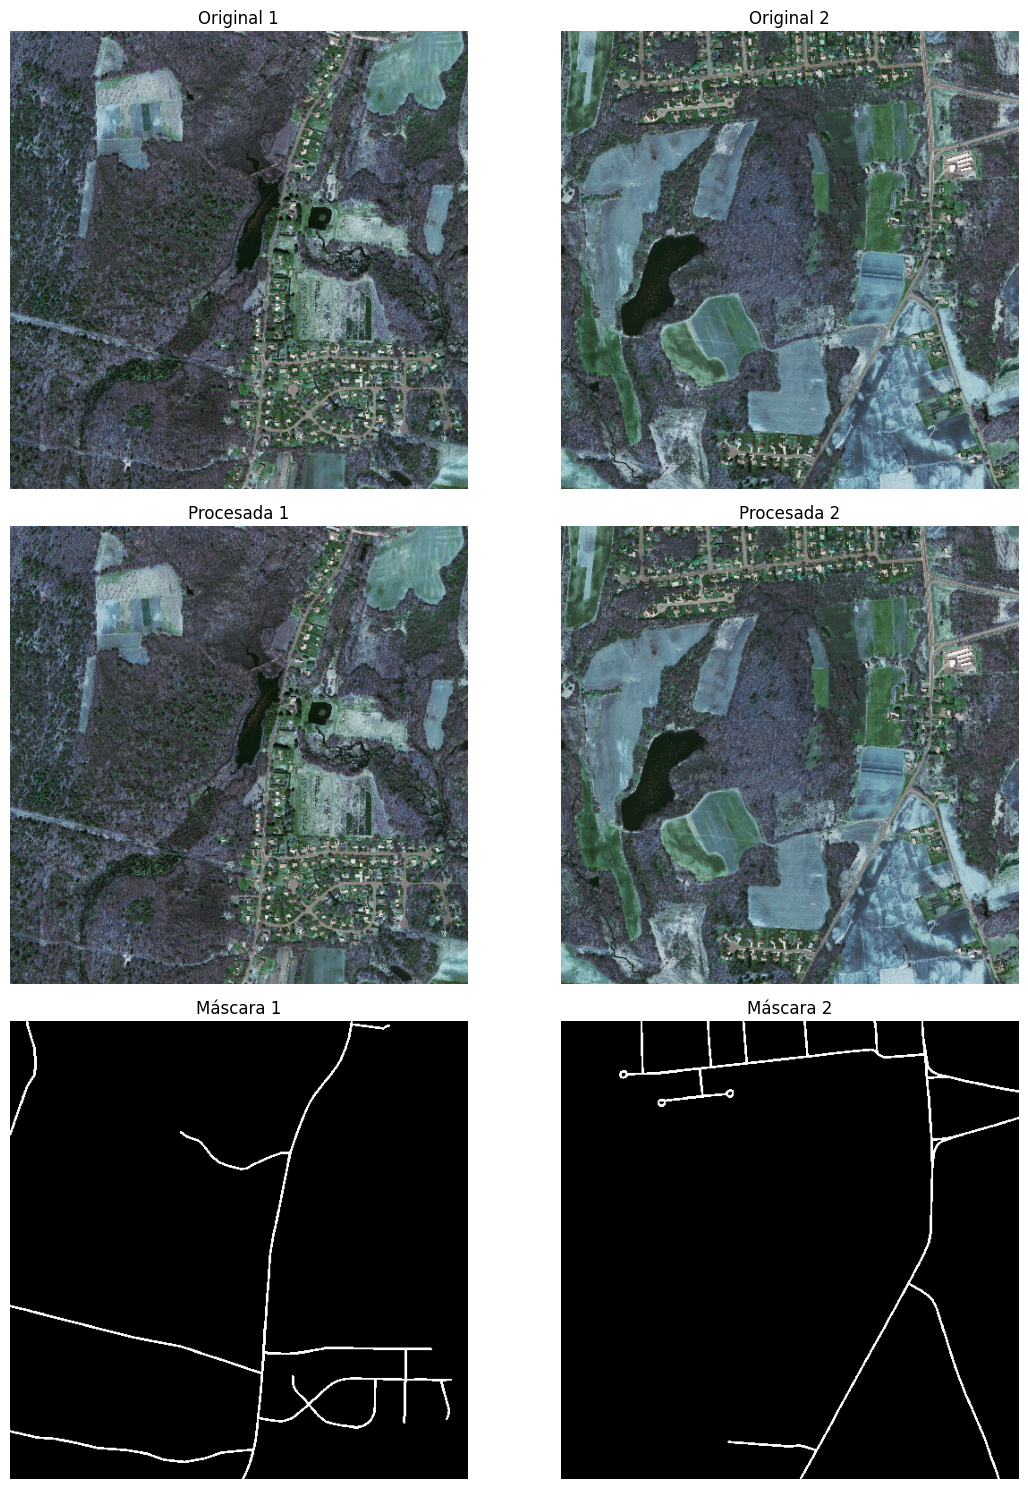

In [97]:
def visualize_preprocessing(images_original, images_processed, masks, num_samples=2):
    _, axs = plt.subplots(3, 2, figsize=(12, 15))
    
    for idx in range(num_samples):
        # Mostrar imagen original
        axs[0, idx].imshow(images_original[idx])
        axs[0, idx].set_title(f'Original {idx+1}')
        axs[0, idx].axis('off')
        
        # Mostrar imagen procesada
        axs[1, idx].imshow(images_processed[idx])
        axs[1, idx].set_title(f'Procesada {idx+1}')
        axs[1, idx].axis('off')
        
        # Mostrar máscara
        axs[2, idx].imshow(masks[idx], cmap='gray')
        axs[2, idx].set_title(f'Máscara {idx+1}')
        axs[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Cargar imágenes originales sin preprocesamiento
IMAGES_ORIGINAL, _ = load_data(img_paths, mask_paths, preprocess=False)

# Visualizar la comparación
visualize_preprocessing(IMAGES_ORIGINAL, IMAGES, MASKS)

# División en Conjunto de Entrenamiento y Test

Para evaluar correctamente el rendimiento de nuestros modelos, dividimos el conjunto de datos en entrenamiento y validación. 

## Proceso de División

Utilizamos `train_test_split` de para realizar una división aleatoria para usarla en `K-folds`:
- __Proporción__: 80% entrenamiento, 20% validación
- __Random state__: 42 (asegura reproducibilidad)


## Verificación de los Datos

Para asegurar que la división se realiza correctamente, realizamos varias comprobaciones:

### 1. Dimensiones de los Conjuntos
- Ambos conjuntos tienen las mismas dimensiones

### 2. Análisis de Valores
- __Rango de valores__ en imágenes: Verificamos que se mantenga en [0,1]
- __Valores únicos en máscaras__: Confirmamos que solo hay 0s y 1s

### 3. Distribución de Clases
- __Proporción de carreteras__: Calculamos el porcentaje de píxeles que representan carreteras, para observar el desbalanceo de clases

In [98]:
# Dividir los datos en conjuntos de entrenamiento y validación (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    IMAGES, 
    MASKS, 
    test_size=0.2, 
    random_state=42
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)

def verify_data():
    # Verificar rango de valores
    print("Rango de valores X_train:", X_train.min(), "-", X_train.max())
    print("Valores únicos en y_train:", np.unique(y_train))
    
    # Calcular proporción de píxeles de carretera vs no carretera
    road_ratio = np.mean(y_train) * 100
    print(f"\nPorcentaje de píxeles de carretera: {road_ratio:.2f}%")

verify_data()

Tamaño del conjunto de entrenamiento: (16, 512, 512, 3)
Tamaño del conjunto de validación: (4, 512, 512, 3)
Rango de valores X_train: 0.007843138 - 1.0
Valores únicos en y_train: [0. 1.]

Porcentaje de píxeles de carretera: 4.19%


# Modelo Baseline (Sin Downsampling ni Extracción de Características)

Como punto de partida, implementamos un modelo baseline simple utilizando Random Forest directamente sobre los valores RGB de los píxeles. Este enfoque nos proporciona una referencia básica para comparar futuras aproximaciones.

## Preparación de los Datos

Para aplicar Random Forest, necesitamos reformatear nuestros datos de imágenes:
- Aplana las imágenes 3D (altura × anchura × canales) a 2D (píxeles × canales)
- Cada fila representa un píxel con sus valores RGB
- Las etiquetas se aplanan de manera correspondiente

## Modelo Random Forest

Configuración del clasificador utilizando previamente `RandomizedSearchCV` para obtener los mejores hiperparametros:
```python
rf_baseline = RandomForestClassifier(
    n_estimators=100,  # Número de árboles
    random_state=42,   # Reproducibilidad
    n_jobs=-1         # Paralelización
)
```

## Métricas de Evaluación
- __Accuracy__: Precisión general
- __F1-Score__: Media armónica entre precisión y recall
- __Precision__: Proporción de verdaderos positivos
- __Recall__: Tasa de detección de positivos reales
- __Dice__: Similaridad entre predicciones y ground truth
- __AUC__: Área bajo la curva ROC

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
import numpy as np

# Preparar los datos en formato 2D (píxeles x características)
X_train_baseline = X_train.reshape(-1, 3)  # Cada píxel con sus 3 canales RGB
y_train_baseline = y_train.reshape(-1)     # Aplanar las máscaras

X_val_baseline = X_val.reshape(-1, 3)
y_val_baseline = y_val.reshape(-1)

print("Forma de X_train_baseline:", X_train_baseline.shape)
print("Forma de y_train_baseline:", y_train_baseline.shape)

# Entrenar un Random Forest básico
rf_baseline = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=2,
        min_samples_split=2,
        n_jobs=-1,  # Usar todos los cores disponibles
        random_state=42
    )

# Entrenar el modelo
rf_baseline.fit(X_train_baseline, y_train_baseline)

# Predicciones
y_pred_baseline = rf_baseline.predict(X_val_baseline)

# Calcular métricas
def calculate_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Dice': 2 * np.sum(y_pred * y_true) / (np.sum(y_pred) + np.sum(y_true)),
        'AUC': roc_auc_score(y_true, y_pred)
    }
    return metrics

baseline_metrics = calculate_metrics(y_val_baseline, y_pred_baseline)
for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

Forma de X_train_baseline: (4194304, 3)
Forma de y_train_baseline: (4194304,)
Accuracy: 0.9492
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Dice: 0.0000
AUC: 0.5000


/home/clown/classroom/PVC_investigacion/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Análisis del Modelo Baseline
## Resultados Obtenidos
En nuestra primera aproximación al problema de segmentación de carreteras, obtuvimos resultados engañosos. Por un lado, alcanzamos una precisión (accuracy) del 94.92%, lo que indicaria que nuestro modelo es excelente para esta clasificación. Sin embargo, el resto de las métricas cuentan una historia muy diferente, con un F1-Score de 0.0000, una precisión (precision) de 0.0000, un recall de 0.0000 y un AUC de 0.5000.

## Interpretación
La alta precisión se debe al gran desbalanceo en nuestros datos, donde la gran mayoría de los píxeles pertenecen a la clase "no-carretera". En estas condiciones, el modelo puede alcanzar una alta precisión simplemente prediciendo la clase mayoritaria en la mayoría de los casos, sin realmente aprender a identificar carreteras de manera efectiva.

Esta interpretación se confirma al examinar las métricas, que nos muestran que el modelo no está identificando correctamente ninguna carretera real, con todas las métricas en 0.

El valor AUC de 0.5000 es interesante, ya que es exactamente el valor que obtendríamos con predicciones aleatorias. Esto indica que nuestro modelo se comporta como un clasificador aleatorio en su capacidad para distinguir entre carreteras y no-carreteras.

## Causas y Soluciones
El principal problema radica en dos aspectos fundamentales que obviamos para obtener el modelo más básico posible. Primero, estamos trabajando con un conjunto de datos altamente desbalanceado, donde los píxeles de carretera son una minoría significativa.

Segundo, nuestro enfoque actual es demasiado simplista en términos de las características utilizadas. Al trabajar únicamente con los valores RGB brutos de cada píxel, estamos ignorando información crucial como la textura, los patrones espaciales, color... que podría ayudar a identificar carreteras de manera más efectiva.

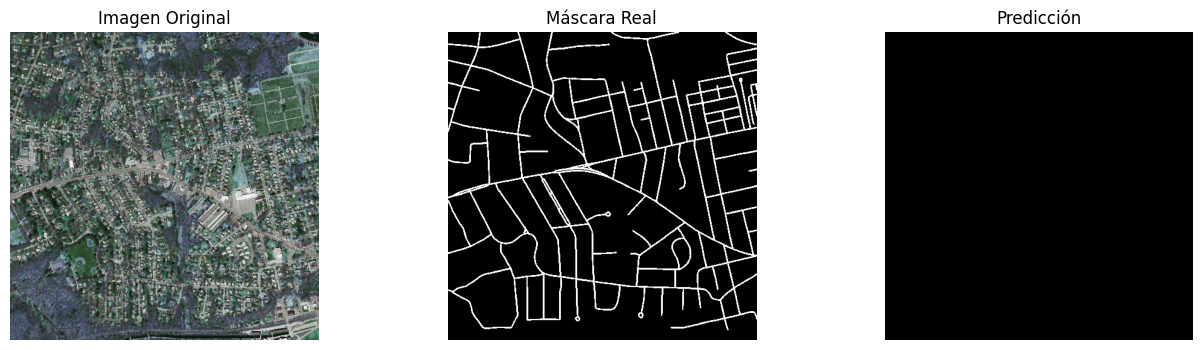

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Reformar las predicciones a la forma de imagen
predictions_reshaped = y_pred_baseline.reshape(X_val.shape[0], 512, 512)

def visualize_predictions(X_val, y_val, predictions, idx=0):

    plt.figure(figsize=(16, 4))

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.title("Imagen Original")
    if X_val[idx].ndim == 3:  # RGB
        plt.imshow(X_val[idx])
    else:  # Grayscale
        plt.imshow(X_val[idx], cmap='gray')
    plt.axis('off')

    # Máscara real
    plt.subplot(1, 3, 2)
    plt.title("Máscara Real")
    plt.imshow(y_val[idx], cmap='gray')
    plt.axis('off')

    # Predicción
    plt.subplot(1, 3, 3)
    plt.title("Predicción")
    plt.imshow(predictions[idx], cmap='gray')
    plt.axis('off')

    plt.show()

# Visualizar para la primera imagen de validación
visualize_predictions(X_val, y_val, predictions_reshaped, idx=1)


# Balanceo de Clases

## Análisis del Desbalanceo Inicial
Inicialmente, nuestros datos presentan un desbalanceo extremo en la distribución de clases:
- __Píxeles de carretera__: 175,556 muestras
- __Píxeles de no-carretera__: 4,018,748 muestras

## Estrategia de Balanceo
Para abordar este desequilibrio, implementamos un pipeline de downsampling sobre la clase mayoritaria (no-carretera). La estrategia consiste en:

1. Mantener todas las muestras de la clase minoritaria (carreteras)
2. Reducir las muestras de no-carretera a un ratio 2:1
   - Se seleccionan aleatoriamente el doble de muestras que la clase minoritaria
3. Combinar ambos conjuntos para obtener un dataset más balanceado

## Resultados del Balanceo
Después de aplicar el downsampling:
- __Total de muestras__: 526,668
- __Ratio carretera/no-carretera__: 1:2 (50%)
- Se mantiene toda la información de carreteras
- Se reduce significativamente el sesgo hacia la clase mayoritaria

In [110]:
from sklearn.utils import resample

# Separar las clases
X_train_road_pipe = X_train_baseline[y_train_baseline == 1]
y_train_road_pipe = y_train_baseline[y_train_baseline == 1]

X_train_noroad_pipe = X_train_baseline[y_train_baseline == 0]
y_train_noroad_pipe = y_train_baseline[y_train_baseline == 0]

print("Antes del balanceo:")
print("Muestras de carretera:", len(X_train_road_pipe))
print("Muestras de no-carretera:", len(X_train_noroad_pipe))

# Downsample la clase mayoritaria (no-carretera)
X_train_noroad_downsampled_pipe = resample(X_train_noroad_pipe,
                                    n_samples=len(X_train_road_pipe) * 2,
                                    random_state=42)
y_train_noroad_downsampled_pipe = np.zeros(len(X_train_noroad_downsampled_pipe))

# Combinar los datos balanceados
X_train_balanced = np.vstack([X_train_road_pipe, X_train_noroad_downsampled_pipe])
y_train_balanced = np.hstack([y_train_road_pipe, y_train_noroad_downsampled_pipe])

print("\nDespués del balanceo:")
print("Muestras totales:", len(X_train_balanced))
print("Ratio carretera/no-carretera:", (len(X_train_road_pipe) / len(X_train_noroad_downsampled_pipe)) * 100,"%")

Antes del balanceo:
Muestras de carretera: 175556
Muestras de no-carretera: 4018748

Después del balanceo:
Muestras totales: 526668
Ratio carretera/no-carretera: 50.0 %


In [ ]:
# Funcion para segmentar el balanceo y entrenamiento para la repetitibilidad
def balance_and_train(X_train, y_train, n_estimators=200, max_depth=10, min_samples_leaf=2, min_samples_split=2):

    # Balancear clases
    X_train_road = X_train[y_train == 1]
    y_train_road = y_train[y_train == 1]

    X_train_noroad = X_train[y_train == 0]

    X_train_noroad_downsampled = resample(X_train_noroad,
                                        n_samples=len(X_train_road) * 2,
                                        random_state=42)
    y_train_noroad_downsampled = np.zeros(len(X_train_noroad_downsampled))

    # Combinar datos balanceados
    X_train_balanced = np.vstack([X_train_road, X_train_noroad_downsampled])
    y_train_balanced = np.hstack([y_train_road, y_train_noroad_downsampled])

    # Entrenar modelo Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_jobs=-1,  # Usar todos los cores disponibles
        random_state=42
    )
    rf_model.fit(X_train_balanced, y_train_balanced)

    return rf_model


# Extracción de Características de Color

1. __Conversión a espacio HSV__: Transformamos las imágenes del espacio BGR a HSV, que separa mejor la información de color (Hue), saturación (Saturation) y brillo (Value).

2. __Extracción de características globales y locales__:
   - Características locales: Valores HSV de cada píxel
   - Características globales: Media y desviación estándar de cada canal HSV
   - Combinación: Se agregan las características globales a cada píxel

## Resultados y Mejoras
Los resultados muestran una mejora significativa respecto al modelo baseline:

- __Accuracy__: 89.54% 
- __F1-Score__: 0.4228 
- __Precision__: 0.2937 
- __Recall__: 0.7547
- __AUC__: 0.8288 

## Analisis
La ligera disminución en accuracy respecto al baseline (89.54% vs 94.92%) representa una mejora significativa, ya que ahora el modelo realmente detecta carreteras en lugar de simplemente predecir la clase mayoritaria.

El recall de 0.7547 es especialmente prometedor, indicando que el modelo encuentra el 75% de las carreteras reales incluso en datos desbalanceados. La precisión más baja (0.2937) es una consecuencia esperada de evaluar en datos no balanceados, donde la gran cantidad de píxeles no-carretera aumenta la probabilidad de falsos positivos. En este contexto de segmentación de carreteras, es preferible tener algunos falsos positivos (precisión más baja) que perder carreteras reales (alto recall).

Tanto el F1-Score como el Dice (ambos 0.4228) parecen bajos porque son métricas que promedian precision y recall, heredando así el impacto del desbalanceo de clases en la precisión. Sin embargo, en el contexto de datos altamente desbalanceados como el nuestro, estos valores son en realidad bastante razonables y no indican necesariamente un mal rendimiento del modelo.

El AUC de 0.8288, siendo una métrica menos sensible al desbalanceo de clases, confirma que el modelo está aprendiendo patrones útiles y discriminando efectivamente entre carreteras y no-carreteras, una mejora sustancial respecto al 0.5000 del baseline que equivalía a predicciones aleatorias.

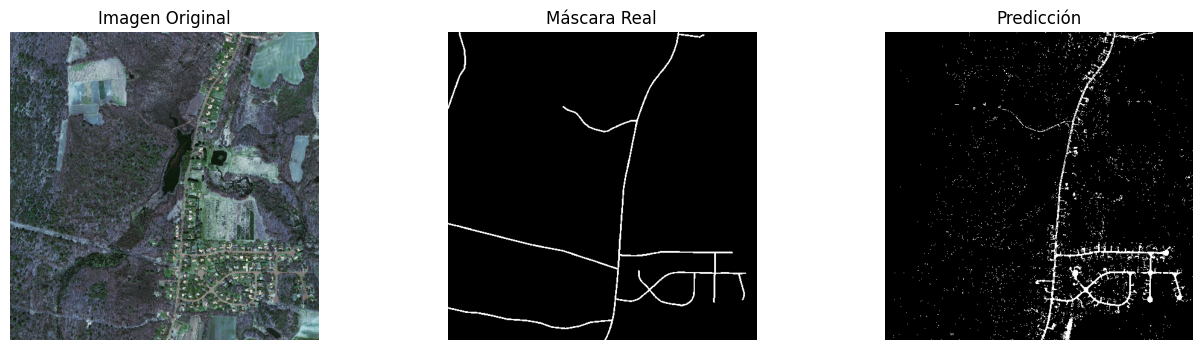

Métricas para características de color:
Accuracy: 0.8954
F1-Score: 0.4228
Precision: 0.2937
Recall: 0.7547
Dice: 0.4228
AUC: 0.8288


In [ ]:
def extract_color_features(images):

    features_list = []
    
    for image in images:
        # Convertir a HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # Calcular estadísticas globales
        mean_hsv = np.mean(hsv, axis=(0,1))
        std_hsv = np.std(hsv, axis=(0,1))
        
        # Obtener características por píxel
        pixel_features = hsv.reshape(-1, 3)
        
        # Replicar estadísticas globales para cada píxel
        global_features = np.tile(
            np.concatenate([mean_hsv, std_hsv]), 
            (pixel_features.shape[0], 1)
        )
        
        # Combinar características locales y globales
        features = np.hstack([pixel_features, global_features])
        features_list.append(features)
    
    return np.vstack(features_list)

X_train_color = extract_color_features(X_train)
X_val_color = extract_color_features(X_val)

# Entrenar modelo con características de color
rf_color = balance_and_train(X_train_color, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_color = rf_color.predict(X_val_color)

# Calcular métricas
color_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_color)

# Visualizar predicciones
predictions_reshaped = y_pred_color.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características de color:")
for metric, value in color_metrics.items():
    print(f"{metric}: {value:.4f}")

# Extracción de Características de Textura

Para este experimento, extraemos características basadas en patrones de textura utilizando Local Binary Patterns (LBP), desviación estándar local y rangos locales. Este enfoque busca capturar los patrones estructurales que podrían diferenciar las carreteras de otros elementos en la imagen.

## Resultados
Los resultados son significativamente inferiores a los obtenidos con características de color:

- El recall de 0.3242 indica que solo detectamos el 32% de las carreteras
- La precisión de 0.1219 sugiere una alta tasa de falsos positivos
- El AUC de 0.5997 está apenas por encima de una predicción aleatoria

## Análisis Visual
La imagen de predicción muestra un problema claro: el modelo está detectando muchas áreas con texturas similares a carreteras (como bordes de edificios y campos) como falsos positivos, mientras que pierde gran parte de las carreteras reales. Esto sugiere que la textura por sí sola no es un discriminador suficientemente fuerte para la detección de carreteras en estas imágenes satelitales.

/home/clown/classroom/PVC_investigacion/Computer-Vision/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


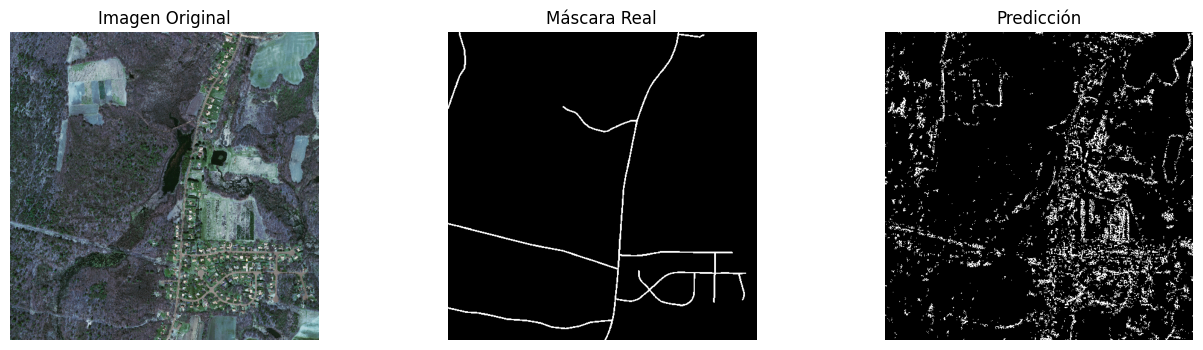

Métricas para características de textura:
Accuracy: 0.8472
F1-Score: 0.1772
Precision: 0.1219
Recall: 0.3242
Dice: 0.1772
AUC: 0.5997


In [ ]:
from skimage.feature import local_binary_pattern
from scipy.ndimage import generic_filter

def extract_texture_features(images, lbp_radius=2, lbp_points=16):
    features_list = []
   
    for img in images:
        # Convertir a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
       
        # Calcular LBP con parámetros mejorados
        lbp = local_binary_pattern(gray, lbp_points, lbp_radius, method='uniform').flatten()
       
        # Calcular desviación estándar local usando convolución
        def local_std_func(block):
            return np.std(block)
        
        local_std = generic_filter(
            gray.astype(float),
            local_std_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()

        # Agregar el rango de valores locales como característica adicional
        def local_range_func(block):
            return block.max() - block.min()
        
        local_range = generic_filter(
            gray.astype(float),
            local_range_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()
       
        # Combinar características
        texture_features = np.column_stack([lbp, local_std, local_range])
        features_list.append(texture_features)
   
    return np.vstack(features_list)

# Extraer las características de textura mejoradas
X_train_texture = extract_texture_features(X_train)
X_val_texture = extract_texture_features(X_val)

# Entrenar modelo con características de textura utilizando la función generalizada
rf_texture = balance_and_train(X_train_texture, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_texture = rf_texture.predict(X_val_texture)

# Calcular métricas
texture_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_texture)

# Visualizar predicciones
predictions_reshaped = y_pred_texture.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características de textura:")
for metric, value in texture_metrics.items():
    print(f"{metric}: {value:.4f}")


# Extracción de Características con Gabor

Para este experimento, implementamos filtros Gabor junto con estadísticas locales para capturar información de textura y orientación. Los filtros Gabor son particularmente útiles para detectar bordes y patrones direccionales, lo que debería ser relevantes para la detección de carreteras.

## Resultados y Comparativa
Los resultados muestran una mejora respecto al modelo de textura básico, pero siguen siendo inferiores al modelo de color:

- El recall aumentó a 0.4089 (vs 0.3242 en textura), detectando más carreteras reales
- La precisión se mantiene baja en 0.1249, similar al modelo de textura
- El AUC mejoró ligeramente a 0.6279, mostrando una mejor capacidad discriminativa

## Análisis Visual
La imagen muestra que el modelo está detectando mejor las estructuras lineales (característica de las carreteras), pero sigue teniendo problemas con:
- Exceso de ruido en la detección
- Confusión con otros elementos del paisaje
- Discontinuidad en las carreteras detectadas

Esto sugiere que los filtros Gabor capturan mejor las carreteras que la textura simple, pero por sí solos no son suficientes para una segmentación precisa.

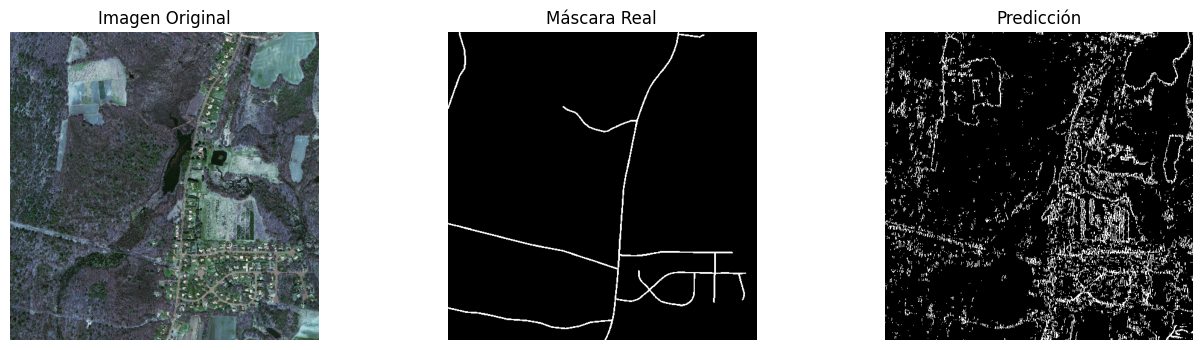

Métricas para características de Gabor:
Accuracy: 0.8246
F1-Score: 0.1913
Precision: 0.1249
Recall: 0.4089
Dice: 0.1913
AUC: 0.6279


In [ ]:
from skimage.filters import gabor
from scipy.ndimage import generic_filter

def extract_gabor_features(images, frequency=0.6):

    features_list = []
    
    for img in images:
        # Convertir a escala de grises
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Aplicar filtro Gabor (frecuencia específica)
        real, _ = gabor(gray, frequency=frequency)
        
        # Calcular desviación estándar local usando convolución
        def local_std_func(block):
            return np.std(block)
        
        local_std = generic_filter(
            gray.astype(float),
            local_std_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()

        # Agregar el rango de valores locales como característica adicional
        def local_range_func(block):
            return block.max() - block.min()
        
        local_range = generic_filter(
            gray.astype(float),
            local_range_func,
            size=(5, 5),
            mode='reflect'
        ).flatten()
        
        # Combinar características (Gabor + Estadísticas locales)
        gabor_features = real.flatten()
        texture_features = np.column_stack([gabor_features, local_std, local_range])
        features_list.append(texture_features)
    
    return np.vstack(features_list)

# Extraer las características usando Gabor
X_train_gabor = extract_gabor_features(X_train)
X_val_gabor = extract_gabor_features(X_val)

# Entrenar modelo con características de Gabor utilizando la función generalizada
rf_gabor = balance_and_train(X_train_gabor, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_gabor = rf_gabor.predict(X_val_gabor)

# Calcular métricas
gabor_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_gabor)

# Visualizar predicciones
predictions_reshaped = y_pred_gabor.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características de Gabor:")
for metric, value in gabor_metrics.items():
    print(f"{metric}: {value:.4f}")


# Extracción de Características con Espectral

Implementamos un extractor de características espectrales que va más allá del uso de canales RGB, incorporando índices de vegetación:

- NDVI (Índice de Vegetación de Diferencia Normalizada)
- SAVI (Índice de Vegetación Ajustado al Suelo)
- EVI (Índice de Vegetación Mejorado)

## Resultados y Comparativa
Los resultados son notablemente buenos, similares o incluso superiores al modelo de color:

- El recall de 0.7779 es el más alto hasta ahora, detectando casi el 78% de las carreteras
- La precisión de 0.2708, aunque baja, es comprensible dado el desbalanceo de datos
- El AUC de 0.8329 es el mejor obtenido hasta ahora, superando al modelo de color (0.8288)

## Análisis Visual
La imagen de predicción muestra una mejora significativa:
- Las carreteras se detectan de manera más continua
- Los bordes están mejor definidos
- Hay menos ruido en áreas no-carretera
- Se mantiene mejor la estructura de las carreteras

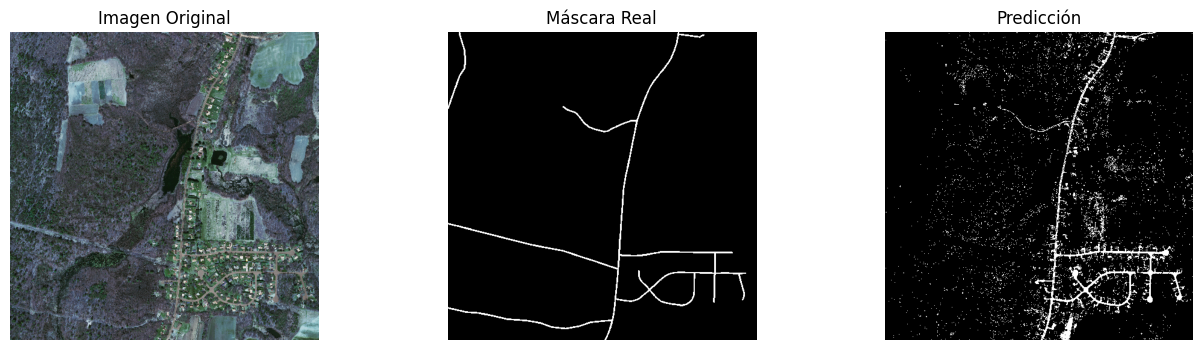

Métricas para características espectrales:
Accuracy: 0.8824
F1-Score: 0.4017
Precision: 0.2708
Recall: 0.7779
Dice: 0.4017
AUC: 0.8329


In [ ]:
def extract_spectral_features(images):

    eps = 1e-6
    features_list = []
    
    for image in images:
        # Extraer canales BGR
        b = image[:, :, 0]
        g = image[:, :, 1]
        r = image[:, :, 2]
        
        # Calcular índices espectrales
        ndvi = (r - b) / (r + b + eps)
        
        L = 0.5  # Factor de ajuste de suelo para SAVI
        savi = ((r - b) * (1 + L)) / (r + b + L)
        
        evi = 2.5 * ((r - b) / (r + 6 * b - 7.5 * g + 1))
        
        # Combinar todas las características para cada imagen
        features = np.column_stack([
            r.flatten(),
            g.flatten(),
            b.flatten(),
            ndvi.flatten(),
            savi.flatten(),
            evi.flatten()
        ])
        
        features_list.append(features)
    
    return np.vstack(features_list)

# Uso:
X_train_spectral = extract_spectral_features(X_train)
X_val_spectral = extract_spectral_features(X_val)

# Entrenar modelo con características espectrales utilizando la función generalizada
rf_spectral = balance_and_train(X_train_spectral, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_spectral = rf_spectral.predict(X_val_spectral)

# Calcular métricas
spectral_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_spectral)

# Visualizar predicciones
predictions_reshaped = y_pred_spectral.reshape(X_val.shape[0], 512, 512)
visualize_predictions(X_val, y_val_baseline.reshape(X_val.shape[0], 512, 512), predictions_reshaped)

# Imprimir métricas
print("Métricas para características espectrales:")
for metric, value in spectral_metrics.items():
    print(f"{metric}: {value:.4f}")


# Extracción de Características con Combinadas

En este experimento final, combinamos todas las características extraídas anteriormente para aprovechar los diferentes aspectos de cada una:

- Características Espectrales: NDVI, SAVI, EVI y canales RGB
- Características Gabor: Patrones direccionales y bordes
- Características de Textura: Patrones LBP y estadísticas locales
- Características de Color: Espacio HSV y estadísticas globales

## Resultados y Análisis Comparativo

- **Accuracy (0.9072)**: La más alta de todos los modelos
- **F1-Score y Dice (0.4572)**: Mejora significativa, indicando un mejor balance entre precisión y recall
- **Precision (0.3251)**: La más alta obtenida, reduciendo falsos positivos
- **Recall (0.7701)**: Mantiene un recall alto similar al modelo espectral
- **AUC (0.8423)**: El mejor valor obtenido, confirmando la superior capacidad discriminativa

## Análisis Visual
La imagen de predicción muestra mejoras cualitativas notables:
- Mejor definición de los bordes de las carreteras
- Menor ruido en áreas no-carretera
- Continuidad mejorada
- Mejor preservación de las carreteras

/home/clown/classroom/PVC_investigacion/Computer-Vision/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


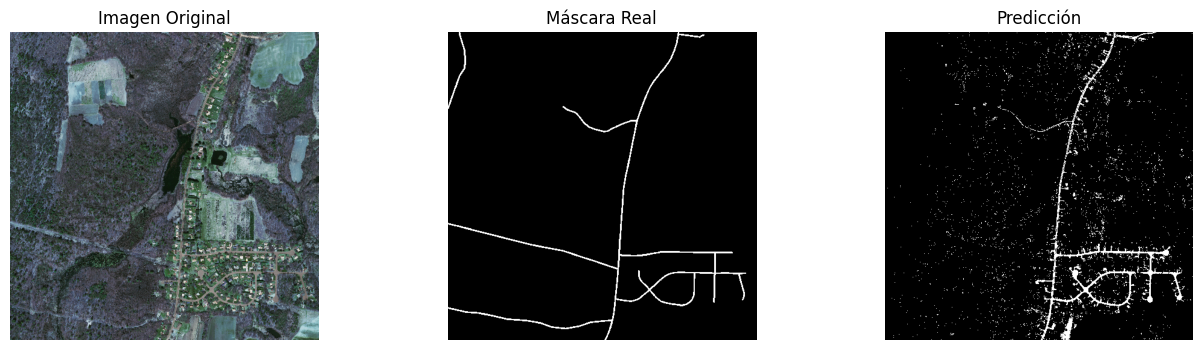

Métricas para características combinadas:
Accuracy: 0.9072
F1-Score: 0.4572
Precision: 0.3251
Recall: 0.7701
Dice: 0.4572
AUC: 0.8423


In [ ]:
# Extraer características espectrales
X_train_spectral = extract_spectral_features(X_train)
X_val_spectral = extract_spectral_features(X_val)

# Extraer características Gabor
X_train_gabor = extract_gabor_features(X_train)
X_val_gabor = extract_gabor_features(X_val)

# Extraer características de textura
X_train_texture = extract_texture_features(X_train)
X_val_texture = extract_texture_features(X_val)

# Extraer características de color
X_train_color = extract_color_features(X_train)
X_val_color = extract_color_features(X_val)

# Combinar todas las características
X_train_all = np.hstack([X_train_spectral, X_train_gabor, X_train_texture, X_train_color])
X_val_all = np.hstack([X_val_spectral, X_val_gabor, X_val_texture, X_val_color])

# Entrenar el modelo con características combinadas utilizando la función generalizada
rf_all = balance_and_train(X_train_all, y_train_baseline)

# Predecir en el conjunto de validación
y_pred_all = rf_all.predict(X_val_all)

# Calcular métricas
all_metrics = calculate_metrics(y_val_baseline.flatten(), y_pred_all)

# Dar forma a las predicciones para visualización
predictions_reshaped = y_pred_all.reshape(X_val.shape[0], 512, 512)

# Dar forma a las etiquetas de validación antes de visualizar
y_val_reshaped = y_val_baseline.reshape(X_val.shape[0], 512, 512)

# Visualizar resultados con las etiquetas re-formadas
visualize_predictions(X_val, y_val_reshaped, predictions_reshaped)

# Imprimir métricas
print("Métricas para características combinadas:")
for metric, value in all_metrics.items():
    print(f"{metric}: {value:.4f}")


# Postprocesado Morfológico


1. **Preparación inicial**:
   - Conversión a uint8 y escalado a [0,255]
   - Suavizado Gaussiano para reducir ruido inicial
   - Binarización con umbral en 100

2. **Operaciones morfológicas**:
   - Dilatación (2×1): Conecta líneas cercanas
   - Erosión asimétrica (2×2): Adelgaza preservando estructuras horizontales
   - Apertura final: Elimina ruido residual

Aunque el postprocesado mejora visualmente algunos aspectos, se eliminan algunas carreteras que no estan tan claras; sobretodo los caminos de tierra. Los cambios son relativamente sutiles y podrían necesitar más ajuste para un impacto más significativo.

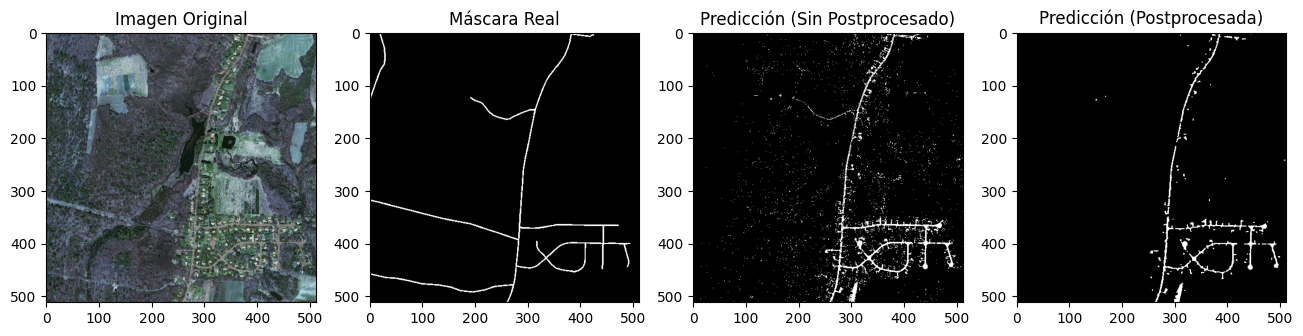

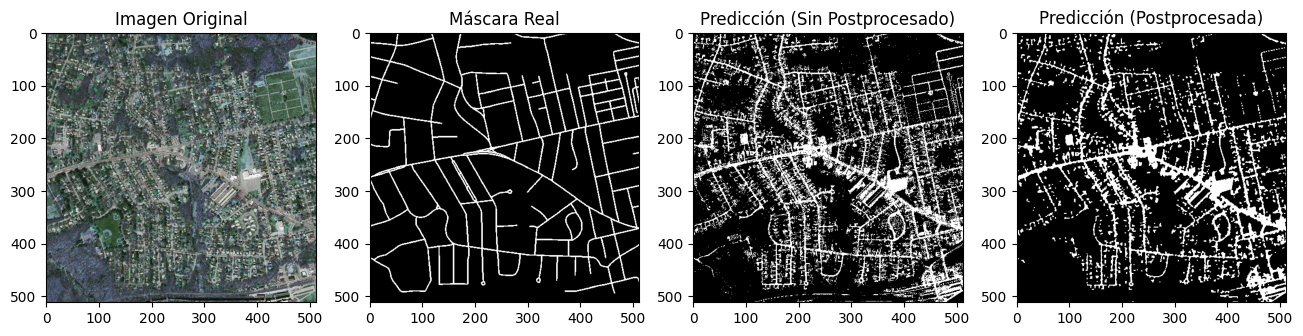

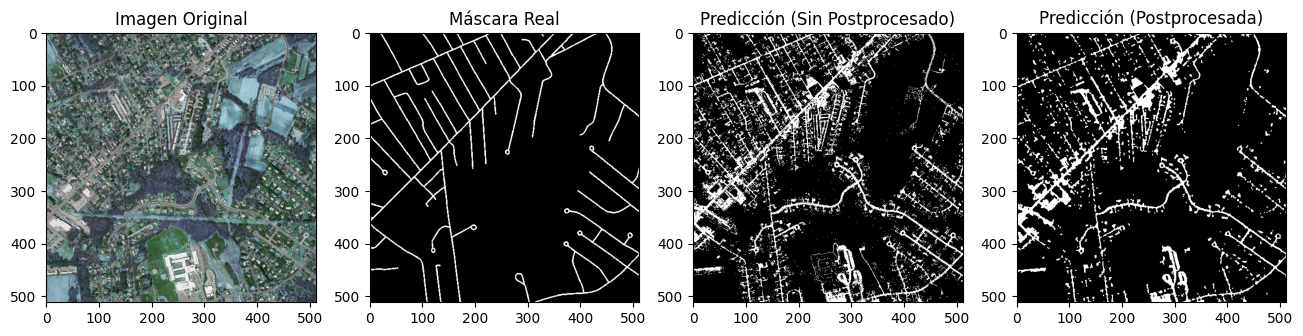

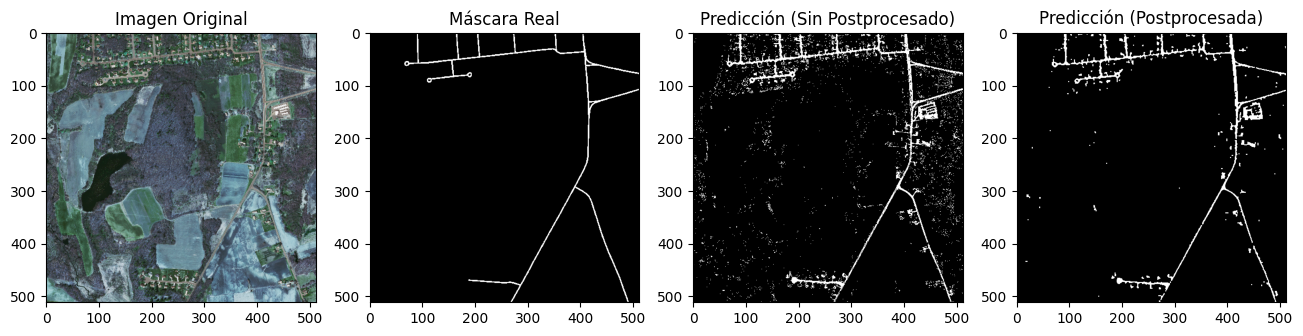

In [129]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Postprocesado de las predicciones
predictions_postprocessed = []
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))  # Dilatación
kernel_erode = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))   # Erosión asimétrica

for pred in predictions_reshaped:
    # Asegurar que los datos están en formato uint8
    pred = (pred * 255).astype(np.uint8)

    # Suavizar ligeramente para eliminar ruido
    pred_smooth = cv2.GaussianBlur(pred, (3, 3), 0)

    # Binarizar la imagen
    _, pred_binary = cv2.threshold(pred_smooth, 100, 255, cv2.THRESH_BINARY)

    # Paso 1: Dilatación para conectar líneas
    pred_post = cv2.dilate(pred_binary, kernel_dilate, iterations=1)

    # Paso 2: Erosión para adelgazar las líneas
    pred_post = cv2.erode(pred_post, kernel_erode, iterations=1)

    # Paso 3: Apertura final para eliminar ruido pequeño
    pred_post = cv2.morphologyEx(pred_post, cv2.MORPH_OPEN, kernel_erode)

    predictions_postprocessed.append(pred_post)

predictions_postprocessed = np.array(predictions_postprocessed)

# Obtener el número máximo de imágenes disponibles, varible según el test
num_images = min(20, len(X_val), len(predictions_postprocessed))

# Visualización de resultados
for i in range(num_images):  
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title("Imagen Original")
    plt.imshow(X_val[i])

    plt.subplot(1, 4, 2)
    plt.title("Máscara Real")
    plt.imshow(y_val_reshaped[i], cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Predicción (Sin Postprocesado)")
    plt.imshow(predictions_reshaped[i], cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title("Predicción (Postprocesada)")
    plt.imshow(predictions_postprocessed[i], cmap='gray')

    plt.show()


# EVALUACION

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_color_distributions(images, title="Distribución de colores"):
    """
    Visualiza la distribución de colores RGB y HSV usando histogramas
    """
    _, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # RGB distribution
    rgb_data = images.reshape(-1, 3)
    colors = ['r', 'g', 'b']
    labels = ['Red', 'Green', 'Blue']
    
    for i, (color, label) in enumerate(zip(colors, labels)):
        axes[0].hist(rgb_data[:, i], bins=50, alpha=0.5, color=color, label=label)
    axes[0].set_title('Distribución RGB')
    axes[0].legend()
    
    # HSV distribution  
    # Convertir las imágenes a uint8 [0-255] antes de la conversión a HSV
    images_uint8 = (images * 255).astype(np.uint8)
    hsv_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in images_uint8])
    hsv_data = hsv_data.reshape(-1, 3)
    
    colors = ['orange', 'purple', 'brown'] 
    labels = ['Hue', 'Saturation', 'Value']
    
    # Crear histogramas separados con rangos apropiados
    axes[1].hist(hsv_data[:, 0], bins=50, range=(0, 180), alpha=0.5, color=colors[0], label=labels[0])
    axes[1].hist(hsv_data[:, 1], bins=50, range=(0, 255), alpha=0.5, color=colors[1], label=labels[1])
    axes[1].hist(hsv_data[:, 2], bins=50, range=(0, 255), alpha=0.5, color=colors[2], label=labels[2])
    
    axes[1].set_title('Distribución HSV')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(y_true, predictions_dict):
   """
   Visualiza matrices de confusión usando imshow
   """
   n_models = len(predictions_dict)
   _, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
   
   for ax, (name, y_pred) in zip(axes, predictions_dict.items()):
       cm = confusion_matrix(y_true, y_pred)
       im = ax.imshow(cm, cmap='Oranges')
       
       # Añadir valores en las celdas
       for i in range(cm.shape[0]):
           for j in range(cm.shape[1]):
               ax.text(j, i, str(cm[i, j]), ha='center', va='center')
       
       ax.set_title(f'Matriz de confusión - {name}')
       ax.set_ylabel('Real')
       ax.set_xlabel('Predicho')
       plt.colorbar(im, ax=ax)
   
   plt.tight_layout()
   plt.show()

def plot_roc_curves(y_true, predictions_dict):
   """
   Visualiza curvas ROC
   """
   plt.figure(figsize=(10, 8))
   
   for name, y_pred in predictions_dict.items():
       fpr, tpr, _ = roc_curve(y_true, y_pred)
       roc_auc = auc(fpr, tpr)
       plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
   
   plt.plot([0, 1], [0, 1], 'k--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.05])
   plt.xlabel('Tasa de Falsos Positivos')
   plt.ylabel('Tasa de Verdaderos Positivos')
   plt.title('Curvas ROC Comparativas')
   plt.legend(loc="lower right")
   plt.grid(True)
   plt.show()


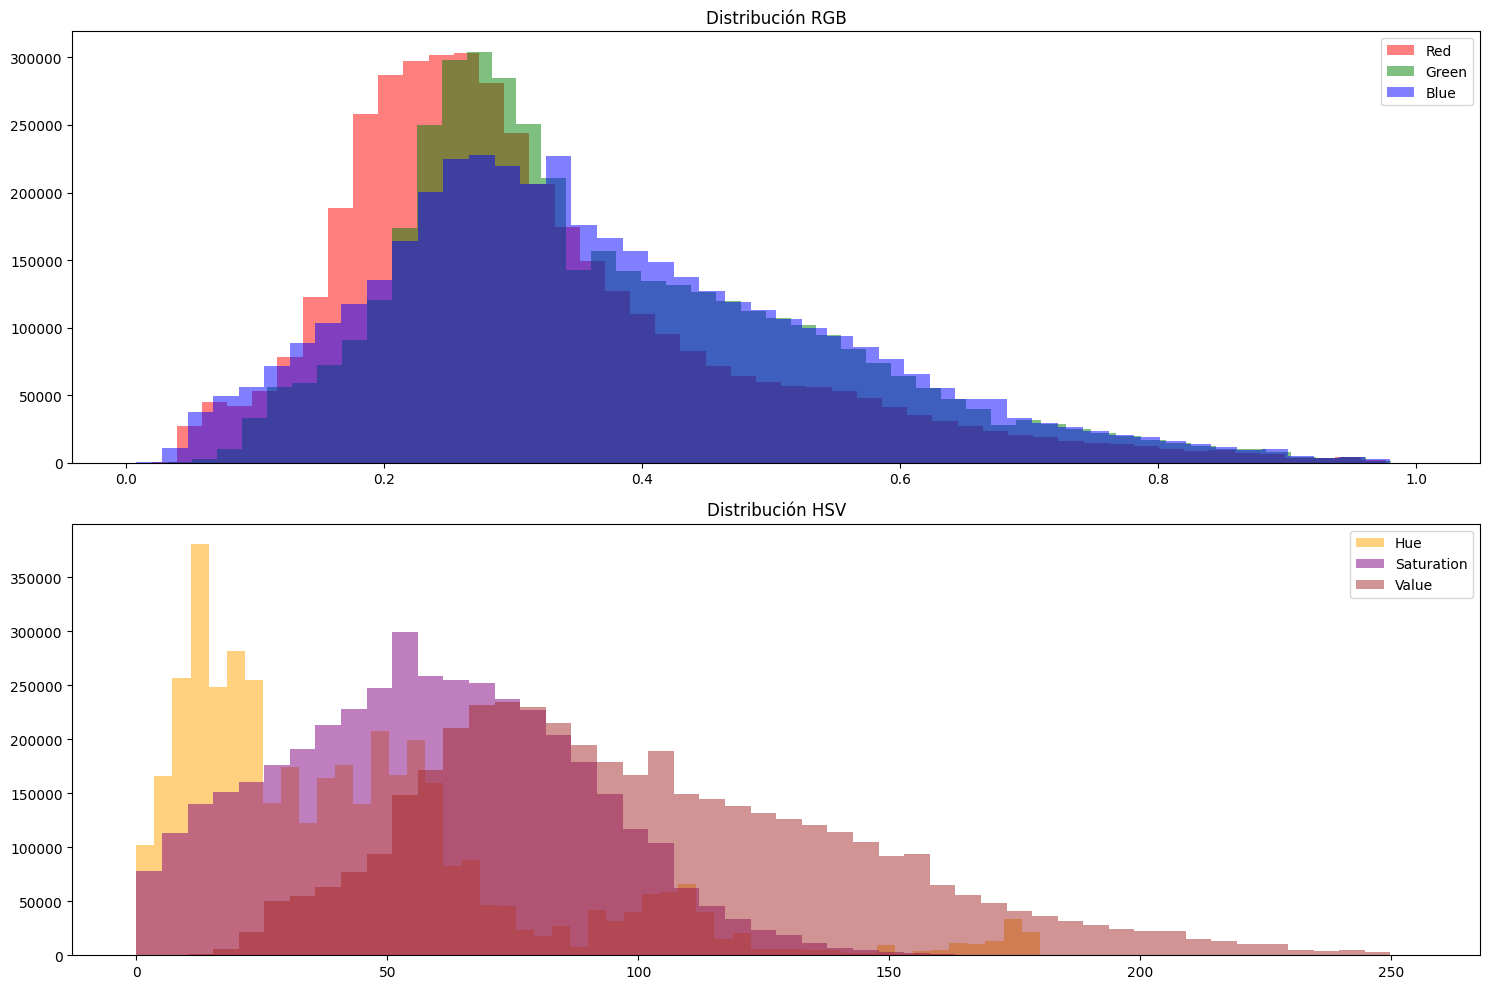

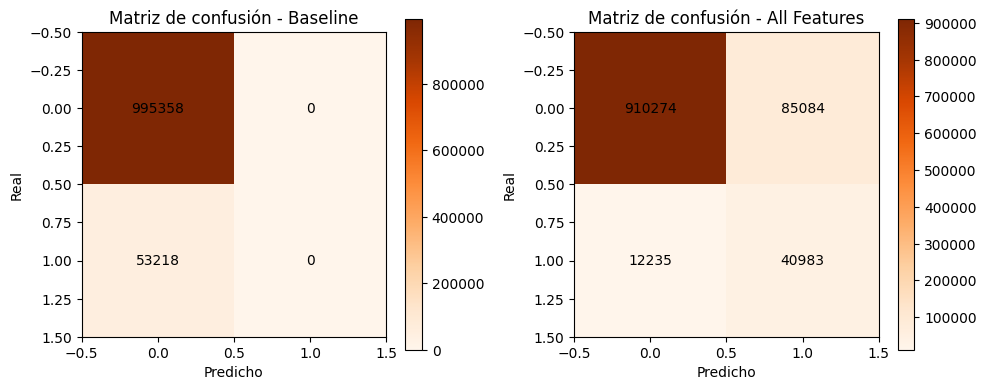

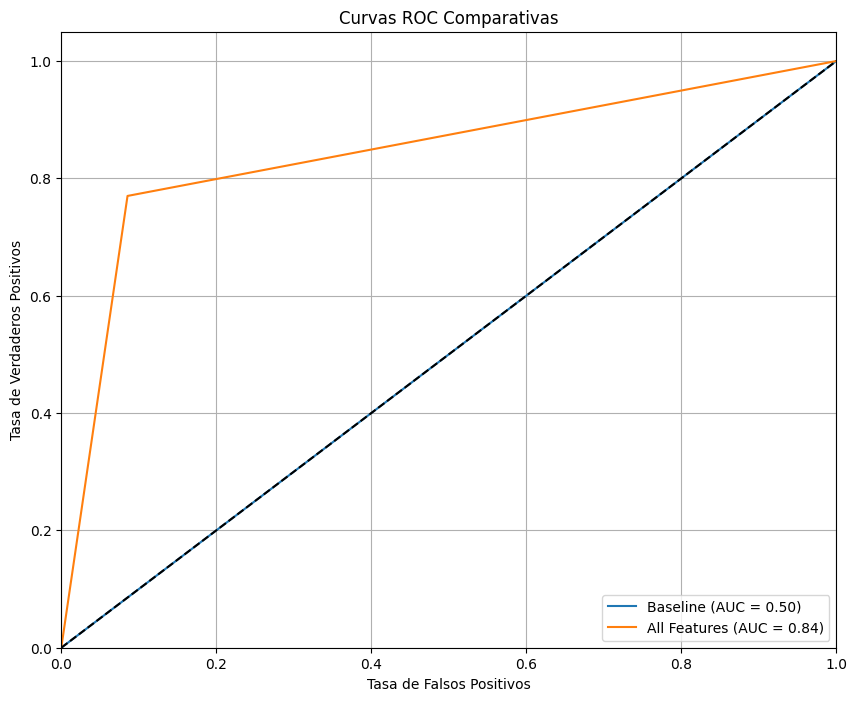

In [ ]:
plot_color_distributions(X_train)
plot_confusion_matrices(y_val_baseline, {'Baseline': y_pred_baseline, 'All Features': y_pred_all})
plot_roc_curves(y_val_baseline, {'Baseline': y_pred_baseline, 'All Features': y_pred_all})

In [ ]:
def create_results_table(experiments):

   # Crear headers
   headers = ['Experimento', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'Dice','AUC']
   
   # Crear filas de datos
   rows = []
   for exp in experiments:
       row = [
           exp['name'],
           f"{exp['metrics']['Accuracy']:.4f}",
           f"{exp['metrics']['F1-Score']:.4f}",
           f"{exp['metrics']['Precision']:.4f}", 
           f"{exp['metrics']['Recall']:.4f}",
           f"{exp['metrics']['Dice']:.4f}",
           f"{exp['metrics']['AUC']:.4f}"
       ]
       rows.append(row)
   
   # Imprimir tabla
   print("\nResultados Comparativos:")
   print("-" * 80)
   print(f"{headers[0]:<20} {headers[1]:<12} {headers[2]:<12} {headers[3]:<12} {headers[4]:<12} {headers[5]:<12} ")
   print("-" * 80)
   for row in rows:
       print(f"{row[0]:<20} {row[1]:<12} {row[2]:<12} {row[3]:<12} {row[4]:<12} {row[5]:<12} ")
   print("-" * 80)

# Ejemplo de uso:
experiments = [
    {
        'name': 'Baseline',
        'metrics': baseline_metrics
    },
    {
            'name': 'Color Features',
            'metrics': color_metrics
    },
    {
        'name': 'Gabor Features',
        'metrics': gabor_metrics
    },
    {
        'name': 'Gabor Features',
        'metrics': spectral_metrics
    },
    {
        'name': 'All Features',
        'metrics': all_metrics
    }
]
create_results_table(experiments)


Resultados Comparativos:
--------------------------------------------------------------------------------
Experimento          Accuracy     F1-Score     Precision    Recall       Dice         
--------------------------------------------------------------------------------
Baseline             0.9492       0.0000       0.0000       0.0000       0.0000       
Color Features       0.8954       0.4228       0.2937       0.7547       0.4228       
Gabor Features       0.8246       0.1913       0.1249       0.4089       0.1913       
Gabor Features       0.8824       0.4017       0.2708       0.7779       0.4017       
All Features         0.9072       0.4572       0.3251       0.7701       0.4572       
--------------------------------------------------------------------------------


## Análisis de Distribuciones de Color
Las distribuciones RGB y HSV nos proporcionan información valiosa sobre las características de las imágenes:

- La **distribución RGB** muestra un patrón con valores concentrados entre 0.2 y 0.4, indicando imágenes generalmente oscuras con predominancia de verdes y azules, típico de imágenes satelitales de zonas rurales/urbanas.

- La **distribución HSV** revela:
  - Tonos (Hue) concentrados en valores específicos, correspondientes a vegetación y estructuras artificiales
  - Saturación moderada, indicando colores no demasiado puros
  - Valores de brillo distribuidos ampliamente, reflejando la variedad de iluminación en la escena

## Análisis de las Matrices de Confusión
La comparación entre el modelo baseline y el modelo con todas las características muestra una mejora significativa:

- **Baseline**: 
  - 995,358 verdaderos negativos
  - 53,218 falsos negativos
  - 0 predicciones positivas
  - Muestra el problema del desbalanceo inicial

- **Todas las características**:
  - 910,274 verdaderos negativos, evidente al tener aun un mayor numero de pixeles "no carretera"
  - 40,983 verdaderos positivos. clasifica correctamente carreteras con una proporcion mayor a la de falsos negativos.
  - Reducción significativa de falsos negativos a 12,235

## Análisis de Curvas ROC
Las curvas ROC muestran una mejora dramática:

- **Baseline**: AUC = 0.50, equivalente a predicción aleatoria
- **Todas las características**: AUC = 0.84, indicando una excelente capacidad discriminativa

## Comparación de Métricas
La evolución a través de los diferentes modelos muestra mejoras progresivas:

1. **Baseline**: Alta accuracy (0.9492) pero métricas nulas en detección de carreteras
2. **Features de Color**: Primera mejora significativa (F1: 0.4228, Recall: 0.7547)
3. **Features Gabor**: Rendimiento peor (F1: 0.1913, Recall: 0.4089)
4. **Features Espectrales**: Buenos resultados (F1: 0.4017, Recall: 0.7779)
5. **Todas las Features**: Mejores resultados globales (F1: 0.4572, Recall: 0.7701)

El modelo final logra el mejor balance entre todas las métricas, combinando las capacidades especificas de cada uno para generar el modelo que mejor identifica las carreteras.